Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


report smallest k-means inertia value, 2d visualization via PCA, confusion matrix, elbow analysis

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5).fit(X)
y_pred = kmeans.labels_ # labels of each point
# Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided
inertia_k5 = kmeans.inertia_

print(f"smallest k means inertia for k=5:  {inertia_k5:.3f}\n")

smallest k means inertia for k=5:  924.316



In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
centers_pca = pca.transform(kmeans.cluster_centers_)

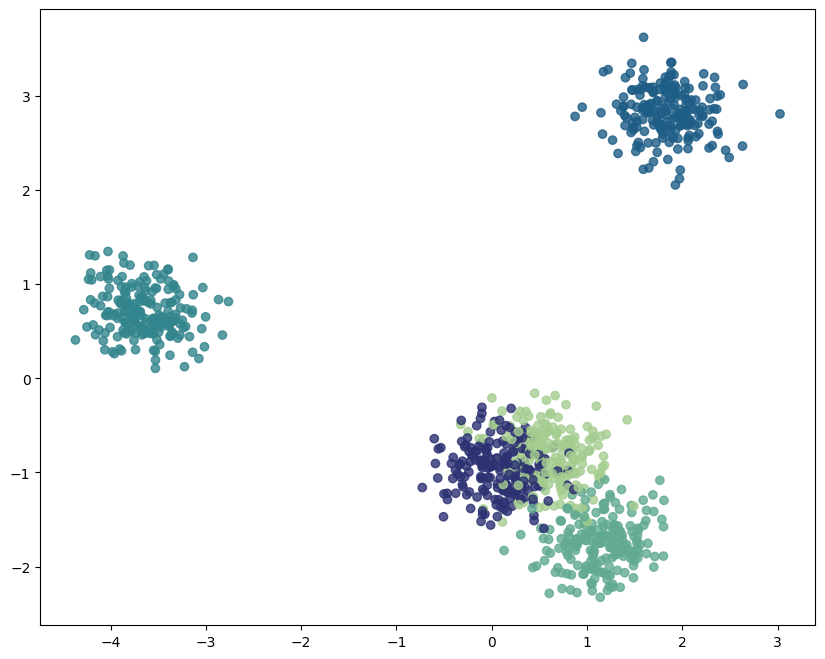

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y_pred,
    cmap='crest',
    alpha=0.8,
    # edgecolors='k',
    linewidth=1
)

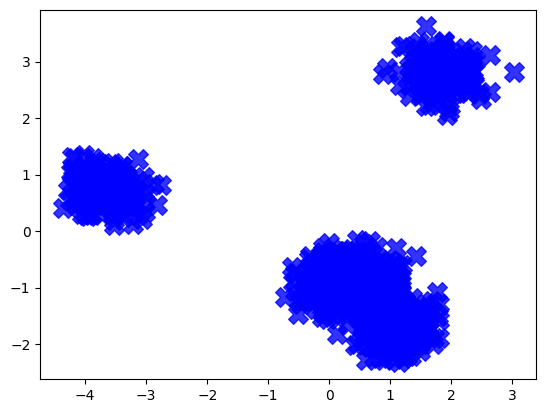

In [27]:
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c='blue',
    alpha=0.8,
    marker='X',
    s=200,
    label='Cluster Centers'
)

# 2. Clustering Fashion-MNIST using $k$-means

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


In [ ]:
# your code here

# 3. Dimensionality reduction for Fashion-MNIST

In [ ]:
# your code here

# 4. Clustering Fashion-MNIST using spectral clustering

In [ ]:
# your code here